# Lip Reading Project
@author : Raby3

##Dependencies##

In [1]:
%%capture
!pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
from typing import List

In [3]:
#Avoiding out of memory errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


##Loading Data##

In [4]:
import gdown

In [5]:
%%capture
#Loading Videos and aligned transcriptions (Annotaions)
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [6]:
#Try the Lip region isolation with Dlib

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #isolate mouth region - Satitically
    cap.release()                              #Original paper uses Dlib

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std #All pixels are Scaled

In [8]:
#Define Vocab
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
#Mapping each word to an index and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size: {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size: 40)


In [24]:
#Loading Alignment
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [31]:
def load_data(path:str):
  path=bytes.decode(path.numpy())
  file_name=path.split('/')[-1].split('.')[0]
  video_path=os.path.join('data','s1',f'{file_name}.mpg')
  alignment_path=os.path.join('data','alignments','s1',f'{file_name}.align')
  frames=load_video(video_path)
  alignments=load_alignments(alignment_path)
  return frames, alignments

In [36]:
test='/content/data/s1/bbaf4p.mpg'
tf.convert_to_tensor(test).numpy().decode('UTF8').split('/')[-1].split('.')[0]

'bbaf4p'

tf.Tensor(b'bin blue at f four please', shape=(), dtype=string)


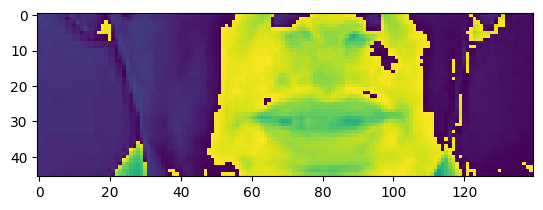

In [48]:
frames,alignements=load_data(tf.convert_to_tensor(test))
plt.imshow(frames[20]) #Due to Scaling the image appears in this way
print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignements).numpy()]))

In [52]:
def mappable_function(video_path)->List[str]: #Wraps Load data function in a py_func
  return tf.py_function(load_data, [video_path], (tf.float32, tf.int64))

##Creating Data Pipeline##

In [83]:
"""data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function) # Turns the path into actual data
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40])) #Takes a pair of video,alignment
                                                                      #Keep Video safe but only 75 frames
                                                                      #Pads the sequence into 40
data=data.prefetch(tf.data.AUTOTUNE)"""
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [84]:
frames, alignments = data.as_numpy_iterator().next()
#plt.imshow(frames[20])
len(frames)
alignments #Variable Length so we need padding
#print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments).numpy()]))

array([[19,  5, 20, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39, 16, 39, 15,
        14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 15, 39, 14,
         9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [94]:
#Extracting an example of Data
sample = data.as_numpy_iterator()
val = sample.next(); val[0]
imageio.mimsave('./animation.gif', val[0][0], fps=10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

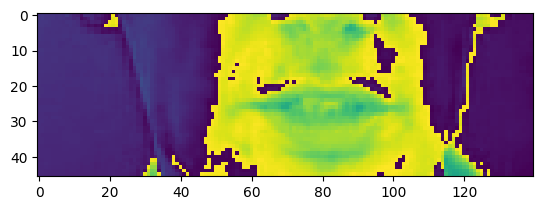

In [93]:
#videos,1stvideo of batsh ,1st frame in vid
plt.imshow(val[0][0][35])

In [95]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(val[1][0]).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green by x zero please'>

##Building the Deep Neural Network##

In [ ]:
#EYYYYYYYYY